위스콘신 유방암 데이터셋

In [17]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [25]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

le.classes_

le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [28]:
# 훈련 8 테스트 2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 파이프라인으로 StandardScaler, PCA, LogisticRegression 연결
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.947


In [30]:
# 파이프라인 구조 시각화
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

---

### k-fold
k-1개의 폴드로 모델훈련, 하나의 폴드로 성능 평가 k번반복 k개의 모델과 성능 추정

독립적인 폴드에서 얻은 성능 추정을 기반으로 모델 평균 성능 계산

기본적으로 k = 10을 사용

In [53]:
# 계층적 k-겹 교차 검증 작동방식
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train) # n_splits=10  폴드 개수 지정
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))
    

# 간단하게
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs=1)
print('CV 정확도 점수:', scores)



폴드:  1, 클래스 분포: [256 153], 정확도: 0.957
폴드:  2, 클래스 분포: [256 153], 정확도: 0.913
폴드:  3, 클래스 분포: [256 153], 정확도: 0.978
폴드:  4, 클래스 분포: [256 153], 정확도: 1.000
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.911
폴드:  7, 클래스 분포: [257 153], 정확도: 0.911
폴드:  8, 클래스 분포: [257 153], 정확도: 0.978
폴드:  9, 클래스 분포: [257 153], 정확도: 0.911
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956
CV 정확도 점수: [0.95652174 0.91304348 0.97826087 1.         0.93478261 0.91111111
 0.91111111 0.97777778 0.91111111 0.95555556]


# grid search

하이퍼 파라미터 전체를 조사하여 모든 조합에 대해 모델 성능을 평가하여 최적의 조합을 찾음

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 42))

param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

# 튜닝하려는 매개변수를 딕셔너리의 리스트로 지정 
# 선형 svm C만 튜닝 RBF 커널 svm C와 gamma 
param_grid = [{'svc__C': param_range,     
               'svc__kernel': ['linear']},
              {'svc__C': param_range,  
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_) # 최상의 모델점수
print(gs.best_params_) # 매개변수

0.9757004830917875
{'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [64]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('테스트 정확도:', clf.score(X_test, y_test))

테스트 정확도: 0.956140350877193


### 랜덤한 하이퍼 파라미터 탐색 RandomizedSearchCV


In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
distribution = loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9736714975845411
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


---

## 성능평가지표

In [66]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[72  0]
 [ 3 39]]


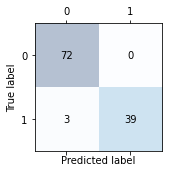

In [67]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
# plt.savefig('images/06_09.png', dpi=300)
plt.show()

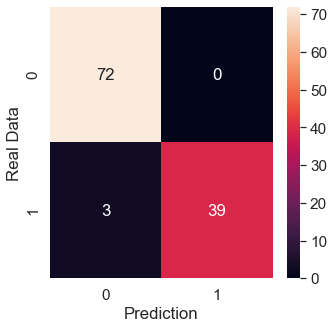

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = pipe_svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
ax = sns.heatmap(cm, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Real Data')
plt.show()

---

### 불균형 데이터 다루기

- 분류기에 있는 class_weight 매개변수를 class_weight = 'balanced'로 설정
- resample, over, under, smote

In [74]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [75]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=42)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [76]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0